# Jonathan Halverson
# Friday, January 5, 2018
# Explicit softmax layer

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

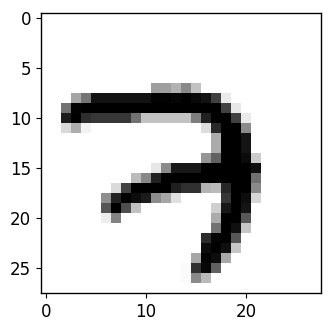

In [4]:
plt.imshow(X_train[0].reshape(28, 28), cmap='binary')

In [5]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [6]:
epochs = 10
batch_size = 50

In [7]:
tf.reset_default_graph()

In [8]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
y_sparse = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y_sparse")

In [9]:
hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
logits  = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [10]:
exp_logits = tf.exp(logits)
sum_rows = tf.reduce_sum(exp_logits, axis=1)
p = exp_logits / tf.reshape(sum_rows, shape=(-1, 1))
num_rows = tf.cast(tf.shape(y_sparse)[0], tf.float32)
loss = -tf.reduce_sum(tf.multiply(y_sparse, tf.log(p + 1e-5))) / num_rows

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

In [12]:
predictions = tf.argmax(p, axis=1)
correct = tf.equal(y, predictions)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
# could also use tf.SparseFeature
def make_sparse(ind):
     sparse2d = np.zeros((ind.size, n_outputs), dtype=np.float32)
     for i in range(ind.size):
          sparse2d[i, ind[i]] = 1
     return sparse2d

In [14]:
y_test_sp = make_sparse(y_test)

In [15]:
init = tf.global_variables_initializer()

In [16]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               y_sp = make_sparse(y_batch)
               sess.run(training_op, feed_dict={X:X_batch, y_sparse:y_sp, y:y_batch})
          ls, ac = sess.run([loss, accuracy], feed_dict={X:X_test, y_sparse:y_test_sp, y:y_test})
          print epoch, ls, ac

0 1.58183 0.665
1 0.999621 0.7993
2 0.718405 0.8385
3 0.582195 0.8635
4 0.504997 0.8772
5 0.454866 0.8852
6 0.419106 0.8914
7 0.393434 0.8953
8 0.373128 0.9006
9 0.357396 0.9025
10 0.344443 0.906


## Non-explicit calculation

In [17]:
tf.reset_default_graph()

In [18]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [19]:
hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
logits  = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [20]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

In [22]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [23]:
init = tf.global_variables_initializer()

In [24]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          ls, ac = sess.run([loss, accuracy], feed_dict={X:X_test, y:y_test})
          print epoch, ls, ac

0 1.56449 0.7176
1 0.963352 0.8158
2 0.696361 0.851
3 0.569587 0.8666
4 0.49748 0.8789
5 0.450321 0.8867
6 0.418054 0.892
7 0.393606 0.8962
8 0.374147 0.9001
9 0.359177 0.9032
10 0.34634 0.9067


The same results are obtained. It would be good to derive y_sparse from y in the graph.